This notebook extends the data loading by adding a minimization step within each data loading iteration loop: it's our real-world usecase.

We use Optax for the optimization procedure. To make sure nothing too crazy happens and that `vmap`ping on the per sample loss computation works as expected, we plot the evolution of the loss and the parameter we are minimizing across minimization steps.

In [1]:
%load_ext autoreload
%autoreload 2

# Loading data

## Xarray data

In [2]:
data_root = "/summer/meom"

In [3]:
import clouddrift as cd
import numpy as np
import xarray as xr

### Drifters

In [4]:
drifter_ds = xr.open_zarr(f"{data_root}/workdir/bertrava/noaa-oar-hourly-gdp-pds.zarr")
drifter_ds

<xarray.Dataset> Size: 102MB
Dimensions:  (traj: 1382, obs: 3189334)
Coordinates:
    id       (traj) int64 11kB dask.array<chunksize=(1382,), meta=np.ndarray>
    time     (obs) datetime64[ns] 26MB dask.array<chunksize=(385186,), meta=np.ndarray>
Dimensions without coordinates: traj, obs
Data variables:
    lat      (obs) float64 26MB dask.array<chunksize=(385186,), meta=np.ndarray>
    lon      (obs) float64 26MB dask.array<chunksize=(385186,), meta=np.ndarray>
    rowsize  (traj) int32 6kB dask.array<chunksize=(1382,), meta=np.ndarray>
    ve       (obs) float32 13MB dask.array<chunksize=(385186,), meta=np.ndarray>
    vn       (obs) float32 13MB dask.array<chunksize=(385186,), meta=np.ndarray>
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centu...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2024-07-30T19:02:16.200531
    doi:                  10.25921/x46c-3620
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program hourly data
    time_coverage_end:    2022-10-31:00:00:00Z
    time_coverage_start:  1987-10-02:13:00:00Z
    title:                Global Drifter Program hourly drifting buoy collection

In [5]:
def chunk_trajectories(
    ds: xr.Dataset, n_days: int = 5, dt: np.timedelta64 = np.timedelta64(1, "h"), to_ragged: bool = False
) -> xr.Dataset:
    def ragged_chunk(arr: xr.DataArray | np.ndarray, is_metadata: bool = False) -> np.ndarray:
        arr = cd.ragged.apply_ragged(cd.ragged.chunk, arr, row_size, chunk_size)  # noqa
        if is_metadata:
            arr = arr[:, 0]
        if to_ragged:
            arr = arr.ravel()
        return arr

    if dt is None:
        dt = (ds.isel(traj=0).time[1] - ds.isel(traj=0).time[0])

    row_size = cd.ragged.segment(ds.time, dt, ds.rowsize)  # if holes, divide into segments
    chunk_size = int(n_days / (dt / np.timedelta64(1, "D"))) + 1

    # chunk along `obs` dimension (data)
    data = dict(
        [(d, ragged_chunk(ds[d])) for d in ["time", "lat", "lon"]]
    )

    # chunk along `traj` dimension (metadata)
    metadata = {"id": ragged_chunk(np.repeat(ds["id"], ds.rowsize), is_metadata=True)}
    metadata["rowsize"] = np.full(metadata["id"].size, chunk_size)  # noqa - after chunking the rowsize is constant

    # create xr.Dataset
    attrs_global = ds.attrs

    coord_dims = {}
    attrs_variables = {}
    for var in ds.coords.keys():
        var = str(var)
        coord_dims[var] = str(ds[var].dims[-1])
        attrs_variables[var] = ds[var].attrs

    for var in data.keys():
        attrs_variables[var] = ds[var].attrs

    for var in metadata.keys():
        attrs_variables[var] = ds[var].attrs

    metadata["drifter_id"] = metadata["id"]  # noqa
    del metadata["id"]
    attrs_variables["drifter_id"] = attrs_variables["id"]
    attrs_variables["id"] = {}

    if to_ragged:
        coords = {"id": np.arange(metadata["drifter_id"].size), "time": data.pop("time")}
        ragged_array = cd.RaggedArray(
            coords, metadata, data, attrs_global, attrs_variables, {"traj": "rows", "obs": "obs"}, coord_dims
        )
        ds = ragged_array.to_xarray()
    else:
        coords = {"id": np.arange(metadata["drifter_id"].size)}
        
        xr_coords = {}
        for var in coords.keys():
            xr_coords[var] = (
                [coord_dims[var]],
                coords[var],
                attrs_variables[var],
            )

        xr_data = {}
        for var in metadata.keys():
            xr_data[var] = (
                ["traj"],
                metadata[var],
                attrs_variables[var],
            )

        for var in data.keys():
            xr_data[var] = (
                ["traj", "obs"],
                data[var],
                attrs_variables[var],
            )

        ds = xr.Dataset(coords=xr_coords, data_vars=xr_data, attrs=attrs_global)

    return ds

In [6]:
traj_ds = chunk_trajectories(drifter_ds)
traj_ds

<xarray.Dataset> Size: 73MB
Dimensions:     (traj: 25069, obs: 121)
Coordinates:
    id          (traj) int64 201kB 0 1 2 3 4 5 ... 25064 25065 25066 25067 25068
Dimensions without coordinates: traj, obs
Data variables:
    rowsize     (traj) int64 201kB 121 121 121 121 121 ... 121 121 121 121 121
    drifter_id  (traj) int64 201kB 72212 72212 72212 72212 ... 39292 41602 41598
    time        (traj, obs) datetime64[ns] 24MB 2010-01-01 ... 2010-12-31T15:...
    lat         (traj, obs) float64 24MB -31.83 -31.84 -31.84 ... 15.44 15.44
    lon         (traj, obs) float64 24MB 84.96 84.97 84.97 ... 152.6 152.6 152.6
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centu...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2024-07-30T19:02:16.200531
    doi:                  10.25921/x46c-3620
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program hourly data
    time_coverage_end:    2022-10-31:00:00:00Z
    time_coverage_start:  1987-10-02:13:00:00Z
    title:                Global Drifter Program hourly drifting buoy collection

### Surface currents

In [7]:
ssc_ds = xr.open_zarr(f"{data_root}/workdir/bertrava/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.125deg_P1D.zarr")
ssc_ds

<xarray.Dataset> Size: 24GB
Dimensions:    (latitude: 1440, longitude: 2880, time: 365)
Coordinates:
  * latitude   (latitude) float32 6kB -89.94 -89.81 -89.69 ... 89.69 89.81 89.94
  * longitude  (longitude) float32 12kB -179.9 -179.8 -179.7 ... 179.8 179.9
  * time       (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
Data variables:
    ugos       (time, latitude, longitude) float64 12GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 12GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.6
    comment:                   Sea Surface Height measured by Altimetry and d...
    contact:                   servicedesk.cmems@mercator-ocean.eu
    copernicusmarine_version:  2.0.1
    history:                   2024-10-23 12:55:06Z: Creation
    institution:               CLS, CNES
    references:                http://marine.copernicus.eu
    source:                    Altimetry measurements
    title:                     DT merged all satellites Global Ocean Gridded ...

## Datasets

In [8]:
from torch.utils.data import Dataset as TorchDataset

In [9]:
class XarrayJAXDataset(TorchDataset):
    def __init__(self, traj_ds: xr.Dataset, ssc_ds: xr.Dataset, ssc_ds_periodic: bool = True):
        self.traj_ds = traj_ds
        self.ssc_ds = ssc_ds
        self.ssc_ds_periodic = ssc_ds_periodic

        max_travel_distance = .5  # in ° / day ; inferred from data
        traj_t0_t1 = traj_ds.time.isel(traj=0)[np.asarray([0, -1])]
        n_days = ((traj_t0_t1[-1] - traj_t0_t1[0]) / np.timedelta64(1, "D")).astype(int).item()
        self.max_travel_distance = max_travel_distance * n_days

        self.ssc_nt = ssc_ds.time.size
        self.ssc_mint = ssc_ds.time.min()
        self.ssc_dt = ssc_ds.time[1] - ssc_ds.time[0]
        self.ssc_t_di = np.ceil(np.timedelta64(n_days, "D") / self.ssc_dt)
        self.ssc_nlat = ssc_ds.latitude.size
        self.ssc_minlat = ssc_ds.latitude.min()
        self.ssc_dlat = ssc_ds.latitude[1] - ssc_ds.latitude[0]  # regular grid
        self.ssc_lat_di = np.ceil(self.max_travel_distance / self.ssc_dlat)
        self.ssc_nlon = ssc_ds.longitude.size
        self.ssc_minlon = ssc_ds.longitude.min()
        self.ssc_dlon = ssc_ds.longitude[1] - ssc_ds.longitude[0]  # regular grid
        self.ssc_lon_di = np.ceil(self.max_travel_distance / self.ssc_dlon)

    def __len__(self):
        return self.traj_ds.traj.size

    def __getitem__(self, idx: int):
        traj_arrays = self.__get_traj_arrays(idx)
        ssc_arrays = self.__get_ssc_arrays(*traj_arrays[:3])

        traj_arrays = [np.asarray(arr) for arr in traj_arrays]  # we would like to return jax.Array
        ssc_arrays = [np.asarray(arr) for arr in ssc_arrays]  # we would like to return jax.Array
        
        return traj_arrays, ssc_arrays
    
    def __get_traj_arrays(self, idx: int):
        traj_subset = self.traj_ds.isel(traj=idx)
        
        traj_lat = traj_subset.lat.values.ravel()
        traj_lon = traj_subset.lon.values.ravel()
        traj_time = traj_subset.time.values.ravel().astype("datetime64[s]").astype(int)  # in seconds
        traj_id = traj_subset.id.values.ravel()
        
        return traj_lat, traj_lon, traj_time, traj_id
    
    def __get_ssc_arrays(self, traj_lat, traj_lon, traj_time):
        def get_latlon_minmax(latlon0_i, latlon_di):
            min_i = (latlon0_i - latlon_di).astype(int).item()
            max_i = (latlon0_i + latlon_di).astype(int).item()
            return min_i, max_i

        def get_pads(min_i, max_i, n):
            padleft = max(0, -min_i)
            min_i = max(0, min_i)
            padright = max(0, max_i - (n - 1))
            max_i = min(n - 1, max_i)
            return (padleft, padright), (min_i, max_i)    

        t0 = traj_time[0].astype("datetime64[s]")
        lat0 = traj_lat[0]
        lon0 = traj_lon[0]

        t0_i = np.floor((t0 - self.ssc_mint) / self.ssc_dt)
        lat0_i = ((lat0 - self.ssc_minlat) / self.ssc_dlat).round()
        lon0_i = ((lon0 - self.ssc_minlon) / self.ssc_dlon).round()

        tmin_i = t0_i.astype(int).item()
        tmax_i = (t0_i + self.ssc_t_di).astype(int).item()
        latmin_i, latmax_i = get_latlon_minmax(lat0_i, self.ssc_lat_di)
        lonmin_i, lonmax_i = get_latlon_minmax(lon0_i, self.ssc_lon_di)

        (t_padleft, t_padright), (tmin_i, tmax_i) = get_pads(tmin_i, tmax_i, self.ssc_nt)
        (lat_padleft, lat_padright), (latmin_i, latmax_i) = get_pads(latmin_i, latmax_i, self.ssc_nlat)
        (lon_padleft, lon_padright), (lonmin_i, lonmax_i) = get_pads(lonmin_i, lonmax_i, self.ssc_nlon)

        ssc_patch = self.ssc_ds.isel(
            time=slice(tmin_i, tmax_i + 1),
            latitude=slice(latmin_i, latmax_i + 1), 
            longitude=slice(lonmin_i, lonmax_i + 1)
        )

        ssc_u = ssc_patch.ugos
        ssc_v = ssc_patch.vgos
        ssc_time = ssc_patch.time.astype("datetime64[s]").astype(int)  # in seconds
        ssc_lat = ssc_patch.latitude
        ssc_lon = ssc_patch.longitude

        if self.ssc_ds_periodic:  # periodic global domain
            if lon_padleft != 0:
                ssc_patch_left = self.ssc_ds.isel(
                    time=slice(tmin_i, tmax_i + 1),
                    latitude=slice(latmin_i, latmax_i + 1), 
                    longitude=slice(self.ssc_nlon - lon_padleft, self.ssc_nlon)  # right part goes to the left
                )
                ssc_u_left = ssc_patch_left.ugos
                ssc_v_left = ssc_patch_left.vgos
                ssc_lon_left = ssc_patch_left.longitude

                ssc_u = np.concat([ssc_u_left, ssc_u], axis=-1)
                ssc_v = np.concat([ssc_v_left, ssc_v], axis=-1)
                ssc_lon = np.concat([ssc_lon_left, ssc_lon])

                lon_padleft = 0

            if lon_padright != 0:
                ssc_patch_right = self.ssc_ds.isel(
                    time=slice(tmin_i, tmax_i + 1),
                    latitude=slice(latmin_i, latmax_i + 1), 
                    longitude=slice(0, lon_padright)  # left part goes to the right
                )
                ssc_u_right = ssc_patch_right.ugos
                ssc_v_right = ssc_patch_right.vgos
                ssc_lon_right = ssc_patch_right.longitude

                ssc_u = np.concat([ssc_u, ssc_u_right], axis=-1)
                ssc_v = np.concat([ssc_v, ssc_v_right], axis=-1)
                ssc_lon = np.concat([ssc_lon, ssc_lon_right])

                lon_padright = 0

        ssc_u = np.pad(
            ssc_u, ((t_padleft, t_padright), (lat_padleft, lat_padright), (lon_padleft, lon_padright)), mode="edge"
        )
        ssc_v = np.pad(
            ssc_v, ((t_padleft, t_padright), (lat_padleft, lat_padright), (lon_padleft, lon_padright)), mode="edge"
        )
        ssc_time = np.pad(ssc_time, (t_padleft, t_padright), mode="edge")
        ssc_lat = np.pad(ssc_lat, (lat_padleft, lat_padright), mode="edge")
        ssc_lon = np.pad(ssc_lon, (lon_padleft, lon_padright), mode="edge")
        
        return ssc_u, ssc_v, ssc_time, ssc_lat, ssc_lon

In [10]:
xr_jax_dataset = XarrayJAXDataset(traj_ds, ssc_ds)

## Dataloader

In [11]:
import dask
import equinox as eqx
import jax.numpy as jnp
from pastax.gridded import Gridded
from pastax.trajectory import Trajectory
from torch.utils.data import DataLoader

In [ ]:
DASK_N_WORKERS = 2  # 4
DL_N_WORKERS = 8
BATCH_SIZE = 64
PREFETCH_FACTOR = 2  # 4

In [13]:
@eqx.filter_jit  # this improves performances
def to_trajectories(traj_arrays):
    traj_lat, traj_lon, traj_time, traj_id = traj_arrays

    traj_latlon = jnp.asarray(jnp.stack((traj_lat, traj_lon), axis=-1))
    trajectories = eqx.filter_vmap(
        lambda _latlon, _time, _id: Trajectory.from_array(values=_latlon, times=_time, id=_id)
    )(
        traj_latlon, jnp.asarray(traj_time), jnp.asarray(traj_id)
    )

    return trajectories


@eqx.filter_jit  # this improves performances
def to_gridded(ssc_arrays):
    ssc_u, ssc_v, ssc_time, ssc_lat, ssc_lon = ssc_arrays
    
    gridded = eqx.filter_vmap(Gridded.from_array)(
        {"u": jnp.asarray(ssc_u), "v": jnp.asarray(ssc_v)}, 
        jnp.asarray(ssc_time), jnp.asarray(ssc_lat), jnp.asarray(ssc_lon)
    )

    return gridded

In [14]:
def xr_jax_collate_fn(batch: ((np.ndarray, ...), (np.ndarray, ...))):
    traj_arrays = [[] for _ in range(4)]
    ssc_arrays = [[] for _ in range(5)]

    for elem in batch:
        _traj_arrays, _ssc_arrays = elem
        
        [traj_arrays[i].append(_traj_arrays[i]) for i in range(len(_traj_arrays))]
        [ssc_arrays[i].append(_ssc_arrays[i]) for i in range(len(_ssc_arrays))]

    traj_arrays = [np.stack(traj_array) for traj_array in traj_arrays]
    ssc_arrays = [np.stack(ssc_array) for ssc_array in ssc_arrays]

    return traj_arrays, ssc_arrays

In [15]:
@eqx.filter_jit  # this improves performances
def to_trajectories(traj_arrays):
    traj_lat, traj_lon, traj_time, traj_id = traj_arrays

    traj_latlon = jnp.asarray(jnp.stack((traj_lat, traj_lon), axis=-1))
    trajectories = eqx.filter_vmap(
        lambda _latlon, _time, _id: Trajectory.from_array(values=_latlon, times=_time, id=_id)
    )(
        traj_latlon, jnp.asarray(traj_time), jnp.asarray(traj_id)
    )

    return trajectories


@eqx.filter_jit  # this improves performances
def to_gridded(ssc_arrays):
    ssc_u, ssc_v, ssc_time, ssc_lat, ssc_lon = ssc_arrays
    
    gridded = eqx.filter_vmap(Gridded.from_array)(
        {"u": jnp.asarray(ssc_u), "v": jnp.asarray(ssc_v)}, 
        jnp.asarray(ssc_time), jnp.asarray(ssc_lat), jnp.asarray(ssc_lon)
    )

    return gridded

# Calibrating

## Defining the dynamics

In [16]:
from pastax.dynamics import StochasticSmagorinskyDiffusion
from pastax.simulator import StochasticSimulator

In [17]:
simulator = StochasticSimulator()
dynamics = StochasticSmagorinskyDiffusion.from_cs(cs=1e-1)

In [18]:
INTEGRATION_DT = 30 * 60  # 30 minutes in seconds
ENSEMBLE_SIZE = 50

In [19]:
def forward(_dynamics, grid, x0, ts, key):
    return simulator(dynamics=_dynamics, args=grid, x0=x0, ts=ts, dt0=INTEGRATION_DT, n_samples=ENSEMBLE_SIZE, key=key)

jitted_forward = eqx.filter_jit(forward)

## Calibration procedure

In [20]:
import time

import jax.random as jrd
import optax

In [21]:
def loss(_dynamics, _grid_batch, _reference_trajectory_batch, _key_batch):
    def pair_residual(traj1, traj2):
        residuals = traj1.liu_index(traj2).value
        residuals = jnp.where(jnp.isnan(residuals), 1, residuals)
        return residuals
    
    def _loss(grid, reference_trajectory, key):
        x0 = reference_trajectory.origin
        ts = reference_trajectory.times.value
        simulated_ensemble = forward(_dynamics, grid, x0, ts, key)
        residuals = simulated_ensemble.crps(reference_trajectory, pair_residual, is_metric_symmetric=False)
        return (residuals ** 2).sum().value
    
    loss_batch = eqx.filter_vmap(_loss)(_grid_batch, _reference_trajectory_batch, _key_batch)
    _loss = loss_batch.mean()

    return _loss, _loss  # for returning both grad and value in forward AD mode

jitted_loss = eqx.filter_jit(loss)
grad_val_loss = eqx.filter_jacfwd(loss, has_aux=True)
jitted_grad_val_loss = eqx.filter_jit(grad_val_loss)

In [ ]:
@eqx.filter_jit
def make_step(_dynamics, _opt_state, _grid_batch, _reference_trajectory_batch, _key_batch, _optim):
    grad, loss_val = grad_val_loss(_dynamics, _grid_batch, _reference_trajectory_batch, _key_batch)
    updates, _opt_state = _optim.update(grad, _opt_state)
    _dynamics = eqx.apply_updates(_dynamics, updates)
    return _dynamics, _opt_state, loss_val

In [23]:
N_EPOCHS = 1
LEARNING_RATE = 1e-3

In [ ]:
def do_calibrate(dynamics, dask_n_workers, batch_size, dl_n_workers, prefetch_factor):
    dask.config.set(scheduler="threads", num_workers=dask_n_workers)

    xr_jax_dataloader = DataLoader(
        xr_jax_dataset,
        batch_size=batch_size, shuffle=True,
        collate_fn=xr_jax_collate_fn,
        num_workers=dl_n_workers, prefetch_factor=prefetch_factor,
        persistent_workers=True, multiprocessing_context="fork"
    )

    key = jrd.key(0)
    optim = optax.chain(optax.zero_nans(), optax.adam(LEARNING_RATE))
    opt_state = optim.init(dynamics)

    losses = []
    cs = []

    t0 = time.time()
    n_samples = 0
    for epoch in range(N_EPOCHS):
        key = jrd.split(key, 1)[0]
        for step, (reference_trajectory_batch, grid_batch) in enumerate(xr_jax_dataloader):
            reference_trajectory_batch = to_trajectories(reference_trajectory_batch)
            grid_batch = to_gridded(grid_batch)
            
            batch_key, key = jrd.split(key, 2)
            key_batch = jrd.split(batch_key, batch_size)

            n_samples += batch_size

            dynamics, opt_state, loss_val = make_step(
                dynamics, opt_state, grid_batch, reference_trajectory_batch, key_batch, optim
            )
            losses.append(loss_val.item())
            cs.append(dynamics.cs.item())
    
    return n_samples, time.time() - t0, losses, cs

In [25]:
n_samples, timing, losses, cs = do_calibrate(dynamics, DASK_N_WORKERS, BATCH_SIZE, DL_N_WORKERS, PREFETCH_FACTOR)
print(f"Calibrate using {n_samples} samples in {timing} seconds")

Calibrate using 25069 samples in 506.7114157676697 seconds


## Calibration results

In [26]:
import matplotlib.pyplot as plt

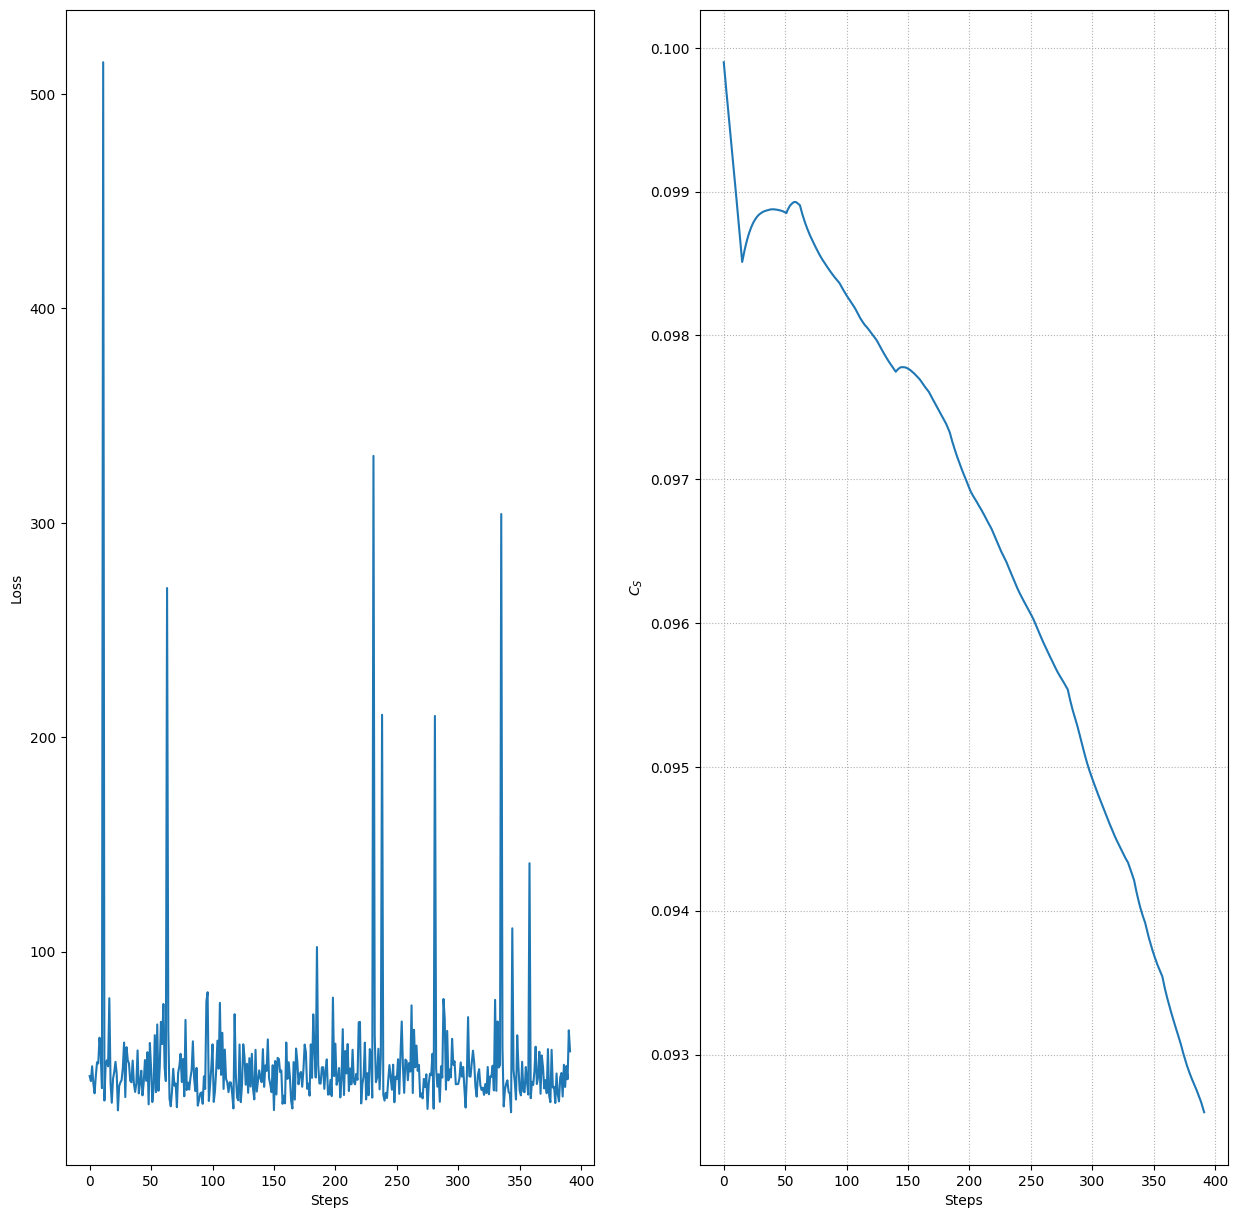

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

ax1.plot(losses)
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss")

ax2.plot(cs)
ax2.set_xlabel("Steps")
ax2.set_ylabel("$C_S$")

plt.grid(True, linestyle=":")
plt.show()